#### Tarea 4
Extracción del promedio de precipitación total para el Altiplano y Sudamérica desde archivos salidas del modelo climático WRF

## Imports librerias

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import os
import matplotlib.pyplot as plt

## Abrir datasets

In [2]:
# Directorio de las salidas WRF
PATH = 'E:/2022-08 WRF python work/WRF data/2003_2004/'
# Abrimos dataset: orography_era5_remaped_latlon_05deg_masl
OROGRAFIA = xr.open_dataset(f'{PATH}orography_era5_remaped_latlon_05deg_masl.nc', chunks=-1)
OROGRAFIA

c:\Users\nicol\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<xarray.Dataset>
Dimensions:  (lon: 131, lat: 111)
Coordinates:
  * lon      (lon) float64 -90.0 -89.5 -89.0 -88.5 ... -26.5 -26.0 -25.5 -25.0
  * lat      (lat) float64 -40.0 -39.5 -39.0 -38.5 -38.0 ... 13.5 14.0 14.5 15.0
Data variables:
    z        (lat, lon) float32 dask.array<chunksize=(111, 131), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Fri Jun 16 11:46:41 2023: cdo -divc,9.81 ororgraphy_era5_re...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

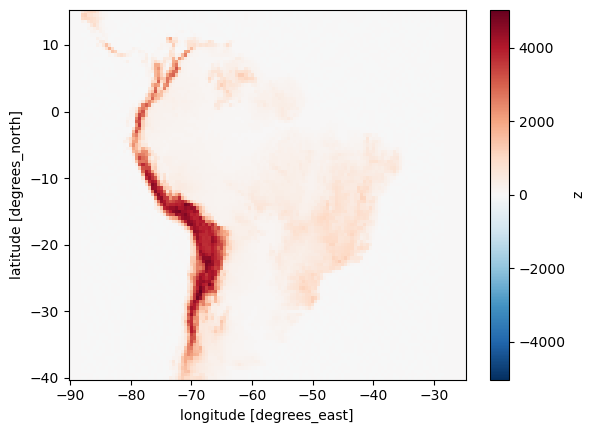

In [3]:
# Visualizamos la variable Z de la OROGRAFIA.
OROGRAFIA['z'].plot()

In [6]:
# Abrimos el dataset monthly_2003_90y.
dataset = xr.open_dataset(f'{PATH}monthly_2003_90y.nc', chunks=-1)
dataset

<xarray.Dataset>
Dimensions:       (air_pressure: 11, Time: 1081, lat: 111, lon: 131)
Coordinates:
  * air_pressure  (air_pressure) float64 100.0 200.0 300.0 ... 800.0 900.0 1e+03
  * Time          (Time) datetime64[ns] 2003-06-01 2003-07-01 ... 2093-06-01
  * lat           (lat) float64 -40.0 -39.5 -39.0 -38.5 ... 13.5 14.0 14.5 15.0
  * lon           (lon) float64 -90.0 -89.5 -89.0 -88.5 ... -26.0 -25.5 -25.0
Data variables: (12/15)
    U10           (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    V10           (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    SNOW          (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    RAINC         (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    RAINNC        (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    PREC_ACC_C    (Time, lat, lon) float32 dask.array<chunksize=(1081, 111, 131), meta=np.ndarray>
    ...            ...
    theta_eq      (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>
    wind_east     (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>
    wind_north    (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>
    W             (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>
    hus           (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>
    ta            (Time, air_pressure, lat, lon) float32 dask.array<chunksize=(1081, 11, 111, 131), meta=np.ndarray>

## Trabajar datos Dataset

### Resample datos dataset

In [7]:
# Para este trabajo solo se utilizará las variables PREC.
# PREC_ACC_C: Precipitación Instantanea Convectiva (mensual).
# PREC_ACC_NC: Precipitación Instantanea no Convectiva (mensual).
# Para calcular la precipitacion total de un  periodo utilizamos la funcion .sum()
PREC_ACC_C = dataset["PREC_ACC_C"].resample(Time='QS-DEC').sum(dim=('Time'))
PREC_ACC_NC = dataset["PREC_ACC_NC"].resample(Time='QS-DEC').sum(dim=('Time'))
SNOW = dataset["SNOW"].resample(Time='QS-DEC').sum(dim=('Time'))
PREC_ACC_C
# OBS: verificar el tiempo, para hacer los recortes de los trimestres despues.

<xarray.DataArray 'PREC_ACC_C' (Time: 361, lat: 111, lon: 131)>
dask.array<stack, shape=(361, 111, 131), dtype=float32, chunksize=(1, 111, 131), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -40.0 -39.5 -39.0 -38.5 -38.0 ... 13.5 14.0 14.5 15.0
  * lon      (lon) float64 -90.0 -89.5 -89.0 -88.5 ... -26.5 -26.0 -25.5 -25.0
  * Time     (Time) datetime64[ns] 2003-06-01 2003-09-01 ... 2093-06-01

### Separar cada trimestre DJF, MAM, JJA, SON

In [8]:
# OBS: verificar el tiempo seleccionado pertenezca efectivamente al trimestre que se le asigna.
# PREC_ACC_C, PREC_ACC_NC y SNOW del trimestre DJF
PREC_ACC_C_DJF = PREC_ACC_C[2::4]
PREC_ACC_NC_DJF = PREC_ACC_NC[2::4]
PREC_TOTAL_DJF = PREC_ACC_C_DJF + PREC_ACC_NC_DJF
SNOW_DJF = SNOW[2::4]

# Precipitacion y nieve total del trimestre MAM
PREC_ACC_C_MAM = PREC_ACC_C[3::4]
PREC_ACC_NC_MAM = PREC_ACC_NC[3::4]
PREC_TOTAL_MAM = PREC_ACC_C_MAM + PREC_ACC_NC_MAM
SNOW_MAM = SNOW[3::4]

# Precipitacion y nieve total del trimestre JJA
PREC_ACC_C_JJA = PREC_ACC_C[0::4]
PREC_ACC_NC_JJA = PREC_ACC_NC[0::4]
PREC_TOTAL_JJA = PREC_ACC_C_JJA + PREC_ACC_NC_JJA
SNOW_JJA = SNOW[0::4]

# Precipitacion y nieve total del trimestre SON
PREC_ACC_C_SON = PREC_ACC_C[1::4]
PREC_ACC_NC_SON = PREC_ACC_NC[1::4]
PREC_TOTAL_SON = PREC_ACC_C_SON + PREC_ACC_NC_SON
SNOW_SON = SNOW[1::4]
print(PREC_TOTAL_DJF.shape, PREC_TOTAL_MAM.shape,
      PREC_TOTAL_JJA.shape, PREC_TOTAL_SON.shape)
print(PREC_ACC_C_DJF[0].Time)
print(SNOW_MAM[0].Time)
print(PREC_ACC_C_JJA[0].Time)
print(PREC_ACC_NC_SON[0].Time)

(90, 111, 131) (90, 111, 131) (91, 111, 131) (90, 111, 131)
<xarray.DataArray 'Time' ()>
array('2003-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2003-12-01
<xarray.DataArray 'Time' ()>
array('2004-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2004-03-01
<xarray.DataArray 'Time' ()>
array('2003-06-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2003-06-01
<xarray.DataArray 'Time' ()>
array('2003-09-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2003-09-01


In [9]:
# Declaramos el altiplano con la orografia en las regiones lat = (-25, -18), lon = (-70,-65)
altiplano = OROGRAFIA['z'].sel(lat = slice(-25, -18), lon = slice(-70,-65))
altiplano

<xarray.DataArray 'z' (lat: 15, lon: 11)>
dask.array<getitem, shape=(15, 11), dtype=float32, chunksize=(15, 11), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -70.0 -69.5 -69.0 -68.5 ... -66.5 -66.0 -65.5 -65.0
  * lat      (lat) float64 -25.0 -24.5 -24.0 -23.5 ... -19.5 -19.0 -18.5 -18.0
Attributes:
    regrid_method:  bilinear

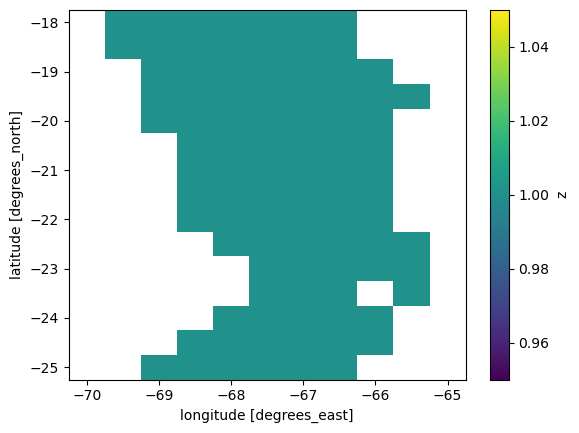

In [10]:
# Filtramos con la orografia sudamerica con un filtro de 3500 mtrs
altiplano_3500 = xr.where(altiplano < 3500, float('nan'), 1) 
altiplano_3500.plot()

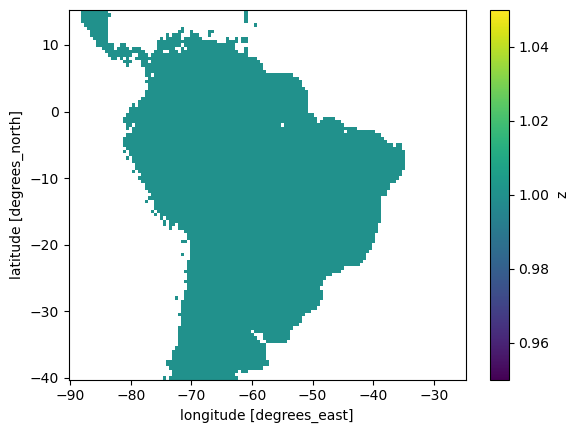

In [11]:
# Filtramos con la orografia sudamerica con un filtro de 10 mtrs
sudamerica_10 = xr.where(OROGRAFIA['z'] < 10, float('nan'), 1) 
sudamerica_10.plot()

### Converger y Filtar datos con sudamerica_10 y altiplano_3500

In [12]:
# Valores PREC_TOTAL y SNOW para altiplano 3500 y sudamerica 10 trimestre DJF
PREC_TOTAL_DJF_SUDAMERICA =  sudamerica_10 * PREC_TOTAL_DJF
SNOW_DJF_SUDAMERICA =  sudamerica_10 * SNOW_DJF
PREC_TOTAL_DJF_ALTIPLANO =  altiplano_3500 * PREC_TOTAL_DJF
SNOW_DJF_ALTIPLANO =  altiplano_3500 * SNOW_DJF

# Valores PREC_TOTAL y SNOW para altiplano 3500 y sudamerica 10 trimestre MAM
PREC_TOTAL_MAM_SUDAMERICA =  sudamerica_10 * PREC_TOTAL_MAM
SNOW_MAM_SUDAMERICA =  sudamerica_10 * SNOW_MAM
PREC_TOTAL_MAM_ALTIPLANO =  altiplano_3500 * PREC_TOTAL_MAM
SNOW_MAM_ALTIPLANO =  altiplano_3500 * SNOW_MAM

# Valores PREC_TOTAL y SNOW para altiplano 3500 y sudamerica 10 trimestre JJA
PREC_TOTAL_JJA_SUDAMERICA =  sudamerica_10 * PREC_TOTAL_JJA  
SNOW_JJA_SUDAMERICA =  sudamerica_10 * SNOW_JJA
PREC_TOTAL_JJA_ALTIPLANO =  altiplano_3500 * PREC_TOTAL_JJA
SNOW_JJA_ALTIPLANO =  altiplano_3500 * SNOW_JJA

# Valores PREC_TOTAL y SNOW para altiplano 3500 y sudamerica 10 trimestre SON
PREC_TOTAL_SON_SUDAMERICA =  sudamerica_10 * PREC_TOTAL_SON
SNOW_SON_SUDAMERICA =  sudamerica_10 * SNOW_SON
PREC_TOTAL_SON_ALTIPLANO =  altiplano_3500 * PREC_TOTAL_SON
SNOW_SON_ALTIPLANO =  altiplano_3500 * SNOW_SON

print(PREC_TOTAL_DJF_SUDAMERICA.shape,PREC_TOTAL_MAM_SUDAMERICA.shape,PREC_TOTAL_JJA_SUDAMERICA.shape,PREC_TOTAL_SON_SUDAMERICA.shape)

(111, 131, 90) (111, 131, 90) (111, 131, 91) (111, 131, 90)


In [13]:
len(PREC_TOTAL_DJF_SUDAMERICA.Time)

90

## DATAFRAME Y EXCEL

In [14]:
# Creamos multiples columnas con la funcion .MultiIndex.from_product()
columns_prec = pd.MultiIndex.from_product([
    # Creamos columnas 'PREC_TOTAL_MEAN', 'PREC_TOTAL_SD', 'SNOW_TOTAL_MEAN', 'SNOW_TOTAL_SD'
    ['PREC_TOTAL_MEAN', 'PREC_TOTAL_SD', 'SNOW_TOTAL_MEAN', 'SNOW_TOTAL_SD'],
    # Creamos subcolumnas 'Sudamerica', 'Altiplano'
    ['Sudamerica', 'Altiplano'],
    # Creamos subcolumnas de las subcolumnas para los trimestres 'DJF', 'MAM', 'JJA', 'SON'
    ['DJF', 'MAM', 'JJA', 'SON']])
# Creamos DataFrame con las columnas columns_prec
df = pd.DataFrame(columns=columns_prec)
# Insertamos en DataFrame columna Year.
df.insert(0, 'Year', np.arange(1, len(PREC_TOTAL_DJF_SUDAMERICA.Time) + 1))
# Vemos como queda el DataFrame
df

Year PREC_TOTAL_MEAN                                         PREC_TOTAL_SD  \
             Sudamerica                Altiplano                   Sudamerica   
                    DJF  MAM  JJA  SON       DJF  MAM  JJA  SON           DJF   
0     1             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
1     2             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
2     3             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
3     4             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
4     5             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
..  ...             ...  ...  ...  ...       ...  ...  ...  ...           ...   
85   86             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
86   87             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
87   88             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
88   89             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   
89   90             NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN           NaN   

    ... SNOW_TOTAL_MEAN      SNOW_TOTAL_SD                                     \
    ...       Altiplano         Sudamerica                Altiplano             
    ...             JJA  SON           DJF  MAM  JJA  SON       DJF  MAM  JJA   
0   ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
1   ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
2   ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
3   ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
4   ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
..  ...             ...  ...           ...  ...  ...  ...       ...  ...  ...   
85  ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
86  ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
87  ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
88  ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   
89  ...             NaN  NaN           NaN  NaN  NaN  NaN       NaN  NaN  NaN   

         
         
    SON  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  
..  ...  
85  NaN  
86  NaN  
87  NaN  
88  NaN  
89  NaN  

[90 rows x 33 columns]

### PREC_TOTAL

##### MEAN

In [15]:
# PREC_TOTAL_MEAN para sudamerica en los trimestres DJF, MAM, JJA, SON.
df['PREC_TOTAL_MEAN', 'Sudamerica', 'DJF'] = pd.Series(PREC_TOTAL_DJF_SUDAMERICA.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Sudamerica', 'MAM'] = pd.Series(PREC_TOTAL_MAM_SUDAMERICA.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Sudamerica', 'JJA'] = pd.Series(PREC_TOTAL_JJA_SUDAMERICA.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Sudamerica', 'SON'] = pd.Series(PREC_TOTAL_SON_SUDAMERICA.mean(dim=('lon', 'lat')))



In [16]:
# PREC_TOTAL_MEAN para el altiplano en los trimestres DJF, MAM, JJA, SON.
df['PREC_TOTAL_MEAN', 'Altiplano', 'DJF'] = pd.Series(PREC_TOTAL_DJF_ALTIPLANO.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Altiplano', 'MAM'] = pd.Series(PREC_TOTAL_MAM_ALTIPLANO.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Altiplano', 'JJA'] = pd.Series(PREC_TOTAL_JJA_ALTIPLANO.mean(dim=('lon', 'lat')))
df['PREC_TOTAL_MEAN', 'Altiplano', 'SON'] = pd.Series(PREC_TOTAL_SON_ALTIPLANO.mean(dim=('lon', 'lat')))


##### STD 

In [17]:
# PREC_TOTAL_SDpara sudamerica en los trimestres DJF, MAM, JJA, SON.
df['PREC_TOTAL_SD', 'Sudamerica', 'DJF'] = pd.Series(PREC_TOTAL_DJF_SUDAMERICA.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Sudamerica', 'MAM'] = pd.Series(PREC_TOTAL_MAM_SUDAMERICA.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Sudamerica', 'JJA'] = pd.Series(PREC_TOTAL_JJA_SUDAMERICA.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Sudamerica', 'SON'] = pd.Series(PREC_TOTAL_SON_SUDAMERICA.std(dim=('lon', 'lat')))


In [18]:
# PREC_TOTAL_SDpara el altiplano en los trimestres DJF, MAM, JJA, SON.
df['PREC_TOTAL_SD', 'Altiplano', 'DJF'] = pd.Series(PREC_TOTAL_DJF_ALTIPLANO.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Altiplano', 'MAM'] = pd.Series(PREC_TOTAL_MAM_ALTIPLANO.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Altiplano', 'JJA'] = pd.Series(PREC_TOTAL_JJA_ALTIPLANO.std(dim=('lon', 'lat')))
df['PREC_TOTAL_SD', 'Altiplano', 'SON'] = pd.Series(PREC_TOTAL_SON_ALTIPLANO.std(dim=('lon', 'lat')))


### Snow

##### TOTAL

In [19]:
# SNOW_TOTAL_MEAN para sudamerica en los trimestres DJF, MAM, JJA, SON.
df['SNOW_TOTAL_MEAN', 'Sudamerica', 'DJF'] = pd.Series(SNOW_DJF_SUDAMERICA.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Sudamerica', 'MAM'] = pd.Series(SNOW_MAM_SUDAMERICA.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Sudamerica', 'JJA'] = pd.Series(SNOW_JJA_SUDAMERICA.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Sudamerica', 'SON'] = pd.Series(SNOW_SON_SUDAMERICA.mean(dim=('lon', 'lat')))


In [20]:
# SNOW_TOTAL_MEAN para el altiplano en los trimestres DJF, MAM, JJA, SON.
df['SNOW_TOTAL_MEAN', 'Altiplano', 'DJF'] = pd.Series(SNOW_DJF_ALTIPLANO.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Altiplano', 'MAM'] = pd.Series(SNOW_MAM_ALTIPLANO.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Altiplano', 'JJA'] = pd.Series(SNOW_JJA_ALTIPLANO.mean(dim=('lon', 'lat')))
df['SNOW_TOTAL_MEAN', 'Altiplano', 'SON'] = pd.Series(SNOW_SON_ALTIPLANO.mean(dim=('lon', 'lat')))


##### STD

In [21]:
# SNOW_TOTAL_SD para sudamerica en los trimestres DJF, MAM, JJA, SON.
df['SNOW_TOTAL_SD', 'Sudamerica', 'DJF'] = pd.Series(SNOW_DJF_SUDAMERICA.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Sudamerica', 'MAM'] = pd.Series(SNOW_MAM_SUDAMERICA.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Sudamerica', 'JJA'] = pd.Series(SNOW_JJA_SUDAMERICA.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Sudamerica', 'SON'] = pd.Series(SNOW_SON_SUDAMERICA.std(dim=('lon', 'lat')))


In [22]:
# SNOW_TOTAL_SD para el altiplano en los trimestres DJF, MAM, JJA, SON.
df['SNOW_TOTAL_SD', 'Altiplano', 'DJF'] = pd.Series(SNOW_DJF_ALTIPLANO.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Altiplano', 'MAM'] = pd.Series(SNOW_MAM_ALTIPLANO.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Altiplano', 'JJA'] = pd.Series(SNOW_JJA_ALTIPLANO.std(dim=('lon', 'lat')))
df['SNOW_TOTAL_SD', 'Altiplano', 'SON'] = pd.Series(SNOW_SON_ALTIPLANO.std(dim=('lon', 'lat')))


## Visualizacion

In [26]:
df.head()

Year PREC_TOTAL_MEAN                                                  \
            Sudamerica                                       Altiplano   
                   DJF         MAM         JJA         SON         DJF   
0    1      724.481191  644.166136  281.111397  518.066247  544.294185   
1    2      718.738705  644.537550  283.205332  519.733079  573.994700   
2    3      721.500302  636.066467  285.578709  516.767895  560.052043   
3    4      722.827832  628.931947  285.900383  511.999695  549.519961   
4    5      732.662265  622.572927  289.100292  510.448152  550.215152   

                                     PREC_TOTAL_SD  ... SNOW_TOTAL_MEAN  \
                                        Sudamerica  ...       Altiplano   
          MAM        JJA         SON           DJF  ...             JJA   
0  157.724833  23.810366  137.600227    518.606467  ...        1.231913   
1  152.833050  27.872988  151.551864    512.521308  ...        1.793081   
2  166.450118  25.476816  132.656888    525.567752  ...        1.622856   
3  163.665413  25.114274  151.840149    533.383588  ...        1.378871   
4  154.768509  26.250148  137.274499    529.434608  ...        1.381210   

            SNOW_TOTAL_SD                                                      \
               Sudamerica                                 Altiplano             
        SON           DJF       MAM        JJA        SON       DJF       MAM   
0  0.331101      1.141431  2.733599  34.560409  21.720159  1.076238  0.890896   
1  0.518155      1.146441  2.660980  35.544261  21.823336  1.367313  0.909831   
2  0.373988      1.730554  2.419285  34.882487  22.117652  1.334925  0.842171   
3  0.583580      1.350340  2.365275  34.895088  22.516331  1.214413  0.786899   
4  0.415005      1.114031  2.258524  34.435386  22.456168  0.957967  0.417697   

                       
                       
        JJA       SON  
0  1.874890  0.508769  
1  2.684846  0.842753  
2  2.363432  0.599735  
3  2.260770  0.895001  
4  2.150096  0.640332  

[5 rows x 33 columns]

In [24]:
PREC_TOTAL_DJF_SUDAMERICA.mean(dim=('lon', 'lat')).values 

array([724.48119065, 718.73870496, 721.50030246, 722.82783243,
       732.66226485, 724.51837141, 715.01163641, 729.84601693,
       732.42679048, 719.74513224, 727.64437279, 724.16867039,
       726.60744864, 721.18530168, 723.12742642, 714.01881376,
       726.386766  , 716.42062471, 716.86042198, 709.69851859,
       720.37174209, 711.47108638, 707.76961618, 704.41745751,
       715.09455979, 709.96729433, 705.53301912, 701.87850452,
       707.66973181, 697.45221877, 697.43800748, 693.33432758,
       702.24083438, 697.0396133 , 689.49188977, 683.990908  ,
       698.42391351, 688.51657227, 683.18721127, 682.22725875,
       691.73570989, 683.57376396, 686.78741129, 685.16518718,
       698.30272293, 686.69256043, 685.39655294, 688.05930506,
       691.73365083, 684.1399366 , 674.47053572, 671.69757083,
       675.9344172 , 668.8012499 , 665.82175518, 668.37053873,
       671.00361785, 661.83981156, 657.08251585, 658.78864334,
       658.59962317, 650.94108257, 649.22509447, 644.71

In [25]:
a = df.to_excel('../Excel/2003_2004.xlsx') # Llevamos el dataframe a excel
